In [1]:
#libraries
import pandas as pd
import numpy as np 
import seaborn as sn
import matplotlib as mt
import sklearn as sk
import scipy as sc
import statsmodels as st
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn import preprocessing
from scipy import stats
from statsmodels import stats
from statsmodels.formula.api import logit, probit, poisson, ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from sklearn.linear_model import LogisticRegression

## data preparation

In [2]:
url = 'https://bitbucket.org/swidrak/swidrak-pochwatko/raw/08903603d07e11f4d48ca78359233e474b94df5b/jmui.xlsx'
data = pd.read_excel(url)

In [3]:
data = data.dropna(how='all')

In [4]:
data.columns

Index([             'study',             'unique',                 'id',
                    'round',          'agent_num',         'agent_name',
                'agent_gen',       'agent_gender',    'participant_pro',
          'participant_gen', 'participant_gender',           'stimulus',
                   'action',        'offer_agent',          'offer_par',
                    'offer',           'accepted',   'masculinity_look',
              'masculinity',       'zmasculinity',        'status_look',
                   'status',            'zstatus',       'pleasantness',
              'awkwardness',           'adequacy',                'age',
                      'edu',       'relationship',                    0,
                          1,                    2,                    3,
                          4,                    5],
      dtype='object')

In [5]:
data['agent'] = data['agent_name'].copy()
data.loc[data.agent_name == 'Karolina', 'agent'] = 'female'
data.loc[data.agent_name == 'Tomek', 'agent'] = 'male'
data.loc[data.agent_name == 'Ania', 'agent'] = 'F feminine'
data.loc[data.agent_name == 'Alan', 'agent'] = 'M effeminate'
data.loc[data.agent_name == 'Daria', 'agent'] = 'F masculine'
data.loc[data.agent_name == 'Pawel', 'agent'] = 'M masculine'
data.loc[data.agent_name == 'Andzelika', 'agent'] = 'F low status'
data.loc[data.agent_name == 'Klara', 'agent'] = 'F high status'
data.loc[data.agent_name == 'Marian', 'agent'] = 'M low status'
data.loc[data.agent_name == 'Karol', 'agent'] = 'M high status'

In [6]:
data['agent']

0              female
1                male
2              female
3                male
4                male
            ...      
8430    M high status
8431    M high status
8432    M high status
8433    M high status
8434    M high status
Name: agent, Length: 8435, dtype: object

In [7]:
print(data['participant_pro'].unique())

[0 1]


In [8]:
res = data[data['participant_pro'] == 0]

In [9]:
one = res[res['study'] == 1]

In [10]:
two = res[res['study'] == 2]

In [11]:
three = res[res['study'] == 3]

In [12]:
gex = res[res['round']<7]

In [13]:
# get p-values in correlations!

from scipy.stats import kendalltau, pearsonr, spearmanr

def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]


## manipulation check

### study 1

In [14]:
#short version

mod = ols('status ~ agent', data=one[one['round']<3]).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print("effect size:")
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("eta square = ", esq_sm)

           sum_sq    df          F    PR(>F)
agent      5476.0   1.0  15.114791  0.000446
Residual  12318.0  34.0        NaN       NaN
effect size:
eta square =  0.3077441834326175


In [15]:
#short version

mod = ols('masculinity ~ agent', data=one[one['round']<4]).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print("effect size:")
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("eta square = ", esq_sm)

                sum_sq    df         F   PR(>F)
agent        14.330095   1.0  0.046877  0.82947
Residual  15284.650675  50.0       NaN      NaN
effect size:
eta square =  0.0009366698856776513


In [16]:
one.groupby('agent')['masculinity'].mean()

agent
female    54.060606
male      55.727273
Name: masculinity, dtype: float64

### study 2

In [17]:
#multiple comparisons test (instead of Bonferroni)
tukey1 = pairwise_tukeyhsd(endog=two.masculinity,     # Data
                          groups=two.agent,   # Groups
                          alpha=0.05)          # Significance level

print(tukey1.summary() )             # See test summary

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper  reject
----------------------------------------------------------------
  F feminine  F masculine    23.55 0.001  20.1543 26.9457   True
  F feminine M effeminate  15.8313 0.001  12.4303 19.2323   True
  F feminine  M masculine  64.0451 0.001  60.6441 67.4461   True
 F masculine M effeminate  -7.7187 0.001 -11.1197 -4.3177   True
 F masculine  M masculine  40.4951 0.001  37.0941 43.8961   True
M effeminate  M masculine  48.2138 0.001  44.8075 51.6202   True
----------------------------------------------------------------


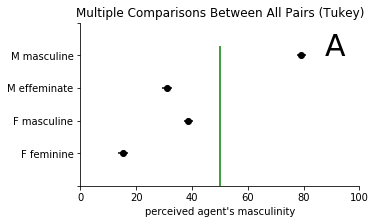

In [18]:
# Plot group confidence intervals
g = tukey1.plot_simultaneous(figsize=(5,3))

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.vlines(x=50, ymin=-1,ymax=3.3, color="g")
plt.xlim(0,100)

#plt.ylabel('agent', labelpad=4)
plt.xlabel("perceived agent's masculinity")

plt.text(x = 95, y = 3, horizontalalignment = 'right', s = "A", fontsize = 30)

g.savefig('masculinity.png', transparent=False)

### study 3

In [19]:
#multiple comparisons test (instead of Bonferroni)
tukey2 = pairwise_tukeyhsd(endog=three.status,     # Data
                          groups=three.agent,   # Groups
                          alpha=0.05)          # Significance level

print(tukey2.summary() )             # See test summary

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2    meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------
F high status  F low status -47.2724  0.001 -49.7322 -44.8127   True
F high status M high status  -3.1921 0.0047  -5.6494  -0.7348   True
F high status  M low status  -27.875  0.001 -30.3323 -25.4177   True
 F low status M high status  44.0803  0.001  41.6218  46.5389   True
 F low status  M low status  19.3974  0.001  16.9389  21.8559   True
M high status  M low status -24.6829  0.001  -27.139 -22.2269   True
--------------------------------------------------------------------


Text(0.5, 0, "perceived agent's social status")

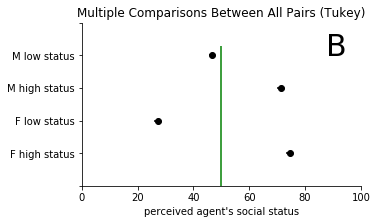

In [20]:
# Plot group confidence intervals
f = tukey2.plot_simultaneous(figsize=(5,3))

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.vlines(x=50, ymin=-1,ymax=3.3, color="g")
plt.xlim(0,100)
plt.text(x = 95, y = 3, horizontalalignment = 'right', s = "B", fontsize = 30)

plt.xlabel("perceived agent's social status")

#f.savefig('status.png', transparent=False)

## touch perception

In [21]:
url = 'https://bitbucket.org/swidrak/swidrak-pochwatko/raw/08903603d07e11f4d48ca78359233e474b94df5b/touch.xlsx'
touch = pd.read_excel(url)

In [22]:
touch.head()

study  id  participant_gender  agent_num  agent_gen agent_gender  \
0      1   3                   1          2          1       female   
1      1   4                   1          2          1       female   
2      1   5                   1          2          1       female   
3      1   6                   1          2          1       female   
4      1   7                   1          2          1       female   

  masculinity  status  natural  surprising  pleasant  weak  adecuate  weird  \
0    feminine  medium        4           4         2     3         3      4   
1    feminine  medium        3           3         4     4         5      1   
2    feminine  medium        2           3         3     3         5      3   
3    feminine  medium        4           3         2     4         5      3   
4    feminine  medium        5           2         2     1         3      4   

   scary  nice  sync  pleasantness  awkwardness  adequacy  
0      3     1     4     -0.616920     0.946847  0.205775  
1      2     4     2      0.915980     0.249687  1.627100  
2      3     3     4      0.135909     0.750030  1.849814  
3      2     2     4     -0.424840     0.604354  2.015430  
4      2     4     4      0.424581    -0.430160 -0.059480

In [23]:
touch1 = touch[touch['study'] == 1]
touch2 = touch[touch['study'] == 2]
touch3 = touch[touch['study'] == 3]

## H1. Perception of agent’s masculinity and social status will influence the evaluation of their touch

### 	H1a. female agents’ touch will be perceived more positively than male agents’ touch.

### study1

### ANOVA

In [24]:
print(touch1.groupby([ 'agent_num'])['pleasantness', 'awkwardness', 'adequacy'].mean())
print(touch1.groupby([ 'agent_num'])['pleasantness', 'awkwardness', 'adequacy'].std())

           pleasantness  awkwardness  adequacy
agent_num                                     
1             -0.746068    -0.116036  0.899764
2              0.017312     0.117210  0.519148
           pleasantness  awkwardness  adequacy
agent_num                                     
1              0.404109     0.782550  1.128986
2              0.601776     0.894768  1.127427


C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [25]:
print(touch1.groupby(['participant_gender'])['pleasantness', 'awkwardness', 'adequacy'].mean())
print(touch1.groupby(['participant_gender'])['pleasantness', 'awkwardness', 'adequacy'].std())

                    pleasantness  awkwardness  adequacy
participant_gender                                     
0                      -0.380748    -0.224202  0.414795
1                      -0.352101     0.169178  0.930451
                    pleasantness  awkwardness  adequacy
participant_gender                                     
0                       0.594534     1.006067  1.248448
1                       0.675549     0.659995  1.004230


C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [26]:
## ANOVA - pleasantness

mod = ols('pleasantness ~ agent_num',
                data=touch1).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

print("effect size:")
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("eta square = ", esq_sm)

              sum_sq    df          F        PR(>F)
agent_num  10.198095   1.0  38.817448  3.350332e-08
Residual   17.864916  68.0        NaN           NaN
effect size:
eta square =  0.3633998818775588


In [27]:
## ANOVA - awkwardness

mod = ols('awkwardness ~ participant_gender',
                data=touch1).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

print("effect size:")
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("eta square = ", esq_sm)

                       sum_sq    df         F    PR(>F)
participant_gender   2.652825   1.0  3.892706  0.052563
Residual            46.341058  68.0       NaN       NaN
effect size:
eta square =  0.05414604875250592


In [28]:
## ANOVA - adequacy

mod = ols('adequacy ~ agent_num*participant_gender',
                data=touch1).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

print("effect size:")
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print("eta square = ", esq_sm)

                                 sum_sq    df         F    PR(>F)
agent_num                      2.535192   1.0  2.059708  0.155961
participant_gender             4.558312   1.0  3.703383  0.058615
agent_num:participant_gender   0.759349   1.0  0.616930  0.435001
Residual                      81.236144  66.0       NaN       NaN
effect size:
eta square =  0.3573963326482186


### correlations

In [29]:
gex1 = one[one['round']<3]

table1 = gex1.groupby('agent_gender')[['zmasculinity', 'pleasantness', 'awkwardness', 'adequacy']].corr('pearson')


signif1 = gex1.groupby('agent_gender')[['zmasculinity', 'pleasantness', 'awkwardness', 'adequacy']].corr(method=pearsonr_pval)

In [30]:
table1

zmasculinity  pleasantness  awkwardness  adequacy
agent_gender                                                                
female       zmasculinity      1.000000     -0.313292     0.436171  0.495484
             pleasantness     -0.313292      1.000000    -0.010912 -0.332387
             awkwardness       0.436171     -0.010912     1.000000  0.673049
             adequacy          0.495484     -0.332387     0.673049  1.000000
male         zmasculinity      1.000000      0.232210     0.346672  0.121205
             pleasantness      0.232210      1.000000     0.056698 -0.433465
             awkwardness       0.346672      0.056698     1.000000  0.678558
             adequacy          0.121205     -0.433465     0.678558  1.000000

In [31]:
signif1

zmasculinity  pleasantness  awkwardness  adequacy
agent_gender                                                                
female       zmasculinity      1.000000      0.205539     0.070368  0.036534
             pleasantness      0.205539      1.000000     0.965724  0.177770
             awkwardness       0.070368      0.965724     1.000000  0.002204
             adequacy          0.036534      0.177770     0.002204  1.000000
male         zmasculinity      1.000000      0.353812     0.158725  0.631879
             pleasantness      0.353812      1.000000     0.823177  0.072329
             awkwardness       0.158725      0.823177     1.000000  0.001963
             adequacy          0.631879      0.072329     0.001963  1.000000

## H1b. lower masculinity of the male agent will be related to a more negative perception of touch

### study 2

### Tukey

In [32]:
print(touch2.groupby('agent_num')['pleasantness', 'awkwardness', 'adequacy'].mean())
print(touch2.groupby('agent_num')['pleasantness', 'awkwardness', 'adequacy'].std())

           pleasantness  awkwardness  adequacy
agent_num                                     
1              0.558184    -0.151460 -0.001551
2             -0.287797     0.295870 -0.427271
3              0.260617    -0.168249 -0.078249
4             -0.145946     0.117137 -0.080135
           pleasantness  awkwardness  adequacy
agent_num                                     
1              0.994701     0.747577  0.915005
2              0.787251     0.897963  0.821759
3              0.758351     0.777616  0.821382
4              0.840152     0.965202  0.931435


C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [33]:
#multiple comparisons test (instead of Bonferroni)

tukey1 = pairwise_tukeyhsd(endog=touch2.pleasantness,     # Data
                          groups=touch2.agent_num,   # Groups
                          alpha=0.005)          # Significance level

tukey1.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

In [34]:
#multiple comparisons test (instead of Bonferroni)

tukey1 = pairwise_tukeyhsd(endog=touch2.pleasantness,     # Data
                          groups=touch2.agent_num,   # Groups
                          alpha=0.05)          # Significance level

tukey1.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

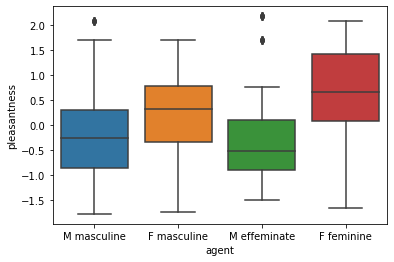

In [35]:
# ADD THE PLOT (maybe better the barplot) TO THE PAPER AFTER SOME LIFTING!!
sn.boxplot(x='agent', y = 'pleasantness', data = two)
#plt.ylim(-.7,.7)

In [36]:
#multiple comparisons test (instead of Bonferroni)

tukey1 = pairwise_tukeyhsd(endog=touch2.adequacy,     # Data
                          groups=touch2.agent_num,   # Groups
                          alpha=0.005)          # Significance level

tukey1.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

### correlations

In [37]:
gex2 = two[two['round'] < 14]

table2 = gex2.groupby('agent_gender')[['zmasculinity', 'pleasantness', 'awkwardness', 'adequacy']].corr('pearson')
table2

zmasculinity  pleasantness  awkwardness  adequacy
agent_gender                                                                
female       zmasculinity      1.000000     -0.010087     0.087287  0.148202
             pleasantness     -0.010087      1.000000    -0.184988  0.216726
             awkwardness       0.087287     -0.184988     1.000000  0.002915
             adequacy          0.148202      0.216726     0.002915  1.000000
male         zmasculinity      1.000000      0.128745    -0.187683  0.147466
             pleasantness      0.128745      1.000000    -0.159818  0.311857
             awkwardness      -0.187683     -0.159818     1.000000 -0.346022
             adequacy          0.147466      0.311857    -0.346022  1.000000

In [38]:
signif2 = gex2.groupby('agent_gender')[['zmasculinity', 'pleasantness', 'awkwardness', 'adequacy']].corr(method=pearsonr_pval)
signif2

zmasculinity  pleasantness  awkwardness  adequacy
agent_gender                                                                
female       zmasculinity      1.000000      0.916700     0.364538  0.122312
             pleasantness      0.916700      1.000000     0.053022  0.022956
             awkwardness       0.364538      0.053022     1.000000  0.975893
             adequacy          0.122312      0.022956     0.975893  1.000000
male         zmasculinity      1.000000      0.190568     0.055209  0.133301
             pleasantness      0.190568      1.000000     0.103413  0.001202
             awkwardness       0.055209      0.103413     1.000000  0.000300
             adequacy          0.133301      0.001202     0.000300  1.000000

### H1c. higher the agent’s social status will be related to a more positive perception of agent’s touch.

### study 3

### Tukey

In [39]:
print(touch3.groupby('agent_num')['pleasantness', 'awkwardness', 'adequacy'].mean())
print(touch3.groupby('agent_num')['pleasantness', 'awkwardness', 'adequacy'].std())

           pleasantness  awkwardness  adequacy
agent_num                                     
1              0.464182    -0.012440 -0.229864
2             -0.017061    -0.044036  0.042357
3             -0.055610     0.046523 -0.340075
4             -0.154460    -0.084347 -0.096478
           pleasantness  awkwardness  adequacy
agent_num                                     
1              1.028616     0.830834  0.795390
2              0.777922     0.795738  0.929867
3              0.824243     0.786708  0.783840
4              0.834634     0.942657  1.026167


C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
C:\Users\justy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [40]:
#multiple comparisons test (instead of Bonferroni)

tukey1 = pairwise_tukeyhsd(endog=touch3.pleasantness,     # Data
                          groups=touch3.agent_num,   # Groups
                          alpha=0.005)          # Significance level

tukey1.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

## correlations

In [41]:
gex3 = three[three['round'] < 10]

table3 = gex3.groupby('agent_gender')[['zstatus', 'pleasantness', 'awkwardness', 'adequacy']].corr('pearson')
table3

zstatus  pleasantness  awkwardness  adequacy
agent_gender                                                            
female       zstatus       1.000000      0.312726    -0.086057  0.077012
             pleasantness  0.312726      1.000000    -0.028690  0.002956
             awkwardness  -0.086057     -0.028690     1.000000  0.024326
             adequacy      0.077012      0.002956     0.024326  1.000000
male         zstatus       1.000000      0.122333     0.006214  0.138096
             pleasantness  0.122333      1.000000    -0.100217  0.361633
             awkwardness   0.006214     -0.100217     1.000000  0.039591
             adequacy      0.138096      0.361633     0.039591  1.000000

In [42]:
signif3 = gex3.groupby('agent_gender')[['zstatus', 'pleasantness', 'awkwardness', 'adequacy']].corr(method=pearsonr_pval)
signif3

zstatus  pleasantness  awkwardness  adequacy
agent_gender                                                            
female       zstatus       1.000000      0.018944     0.528278  0.572655
             pleasantness  0.018944      1.000000     0.833750  0.982748
             awkwardness   0.528278      0.833750     1.000000  0.858755
             adequacy      0.572655      0.982748     0.858755  1.000000
male         zstatus       1.000000      0.299111     0.958095  0.240653
             pleasantness  0.299111      1.000000     0.395570  0.001547
             awkwardness   0.958095      0.395570     1.000000  0.737695
             adequacy      0.240653      0.001547     0.737695  1.000000

In [43]:
def prob(x):
    OD = x / (1 + x)
    return OD

## compliance - Generalized Linear Model

### study 1

In [44]:
formula = "accepted ~  offer_par + action*agent_gender + participant_gender"
mod1 = smf.glm(formula=formula, data=one, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               accepted   No. Observations:                  660
Model:                            GLM   Df Residuals:                      652
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -324.60
Date:                Tue, 19 May 2020   Deviance:                       649.19
Time:                        10:04:49   Pearson chi2:                     690.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


probability:  
 Intercept                               0.155128
action[T.none]                          0.538673
action[T.touch]                         0.645005
agent_gender[T.male]                    0.496490
participant_gender[T.male]              0.357622
action[T.none]:agent_gender[T.male]     0.514505
action[T.touch]:agent_gender[T.male]    0.349130
offer_par                               0.628795
dtype: float64


(0, 1)

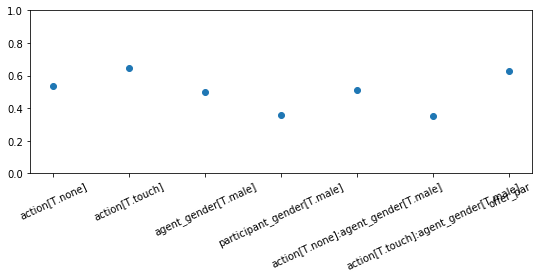

In [45]:
OR1=np.exp(mod1.params)
print("probability: ", '\n', prob(OR1))

plt.figure(figsize=(9,3))
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=25)
         
plt.plot(prob(OR1)[1:], 'o')
plt.ylim(0,1)

In [46]:
print('T-values: ',"\n", mod1.tvalues)
print('Wald chi2: /',"\n", mod1.wald_test_terms())

T-values:  
 Intercept                              -3.726463
action[T.none]                          0.471674
action[T.touch]                         1.639286
agent_gender[T.male]                   -0.043069
participant_gender[T.male]             -2.990104
action[T.none]:agent_gender[T.male]     0.121699
action[T.touch]:agent_gender[T.male]   -1.291044
offer_par                               7.434053
dtype: float64
Wald chi2: / 
                           chi2        P>chi2  df constraint
Intercept            13.886529  1.941853e-04              1
action                2.782320  2.487866e-01              2
agent_gender          0.001855  9.656464e-01              1
participant_gender    8.940721  2.788826e-03              1
action:agent_gender   2.321072  3.133183e-01              2
offer_par            55.265149  1.053194e-13              1


### study 2

In [47]:
formula2 = "accepted ~  offer_par + action*agent + zmasculinity"
mod2 = smf.glm(formula=formula2, data=two, family=sm.families.Binomial()).fit()
print(mod2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               accepted   No. Observations:                 1914
Model:                            GLM   Df Residuals:                     1900
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -716.89
Date:                Tue, 19 May 2020   Deviance:                       1433.8
Time:                        10:04:50   Pearson chi2:                 3.76e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

probability:  
 Intercept                                0.065993
action[T.none]                           0.439705
action[T.touch]                          0.517122
agent[T.F masculine]                     0.403982
agent[T.M effeminate]                    0.399384
agent[T.M masculine]                     0.407094
action[T.none]:agent[T.F masculine]      0.663013
action[T.touch]:agent[T.F masculine]     0.481299
action[T.none]:agent[T.M effeminate]     0.638331
action[T.touch]:agent[T.M effeminate]    0.507950
action[T.none]:agent[T.M masculine]      0.477124
action[T.touch]:agent[T.M masculine]     0.424104
offer_par                                0.709306
zmasculinity                             0.545476
dtype: float64


(0, 1)

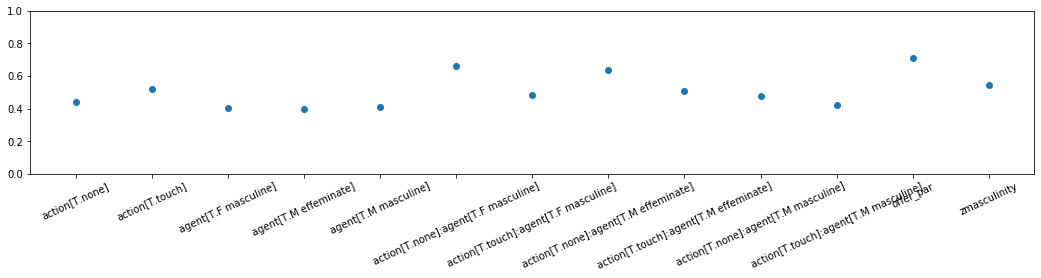

In [48]:
OR2=np.exp(mod2.params)

plt.figure(figsize=(18,3))
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=25)
         
plt.plot(prob(OR2)[1:], 'o')
print("probability: ", '\n', prob(OR2))
plt.ylim(0,1)

In [49]:
print('T-values: ',"\n", mod2.tvalues)
print('Wald chi2: /',"\n", mod2.wald_test_terms())

T-values:  
 Intercept                                -8.127491
action[T.none]                           -0.733208
action[T.touch]                           0.209182
agent[T.F masculine]                     -1.135176
agent[T.M effeminate]                    -1.246087
agent[T.M masculine]                     -0.928147
action[T.none]:agent[T.F masculine]       1.448413
action[T.touch]:agent[T.F masculine]     -0.162194
action[T.none]:agent[T.M effeminate]      1.214156
action[T.touch]:agent[T.M effeminate]     0.070544
action[T.none]:agent[T.M masculine]      -0.192982
action[T.touch]:agent[T.M masculine]     -0.659024
offer_par                                18.964018
zmasculinity                              2.195179
dtype: float64
Wald chi2: / 
                     chi2        P>chi2  df constraint
Intercept      66.056113  4.382665e-16              1
action          1.027068  5.983771e-01              2
agent           1.884513  5.967187e-01              3
action:agent    5.256543  5

### study 3

In [50]:
formula3 = "accepted ~  offer_par + action*agent + zstatus"
mod3 = smf.glm(formula=formula3, data=three, family=sm.families.Binomial()).fit()
print(mod3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               accepted   No. Observations:                 1965
Model:                            GLM   Df Residuals:                     1951
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -894.27
Date:                Tue, 19 May 2020   Deviance:                       1788.5
Time:                        10:04:50   Pearson chi2:                 2.41e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

probability: 
 Intercept                                 0.025206
action[T.none]                            0.646392
action[T.touch]                           0.519384
agent[T.F low status]                     0.772215
agent[T.M high status]                    0.532161
agent[T.M low status]                     0.698166
action[T.none]:agent[T.F low status]      0.294399
action[T.touch]:agent[T.F low status]     0.489070
action[T.none]:agent[T.M high status]     0.406982
action[T.touch]:agent[T.M high status]    0.487508
action[T.none]:agent[T.M low status]      0.345619
action[T.touch]:agent[T.M low status]     0.393339
offer_par                                 0.731949
zstatus                                   0.565910
dtype: float64


(0, 1)

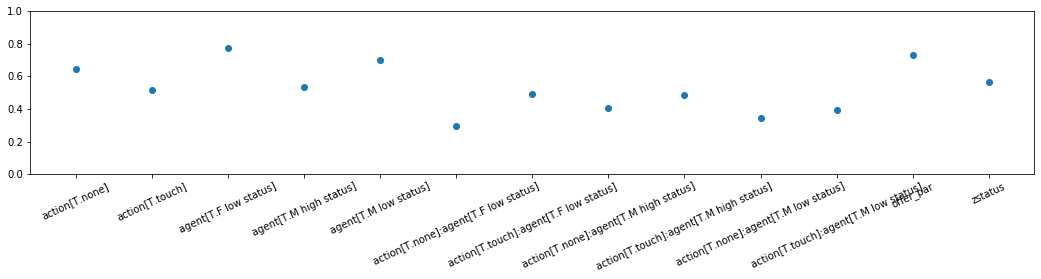

In [51]:
OR3=np.exp(mod3.params)
print("probability:", '\n', prob(OR3))

plt.figure(figsize=(18,3))
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=25)
         
plt.plot(prob(OR3)[1:], 'o')
plt.ylim(0,1)

In [52]:
print('T-values: ',"\n", mod3.tvalues)
print('Wald chi2: /',"\n", mod3.wald_test_terms())

T-values:  
 Intercept                                -12.550587
action[T.none]                             2.061391
action[T.touch]                            0.269443
agent[T.F low status]                      3.474081
agent[T.M high status]                     0.444892
agent[T.M low status]                      2.713184
action[T.none]:agent[T.F low status]      -2.112112
action[T.touch]:agent[T.F low status]     -0.107275
action[T.none]:agent[T.M high status]     -0.924999
action[T.touch]:agent[T.M high status]    -0.122388
action[T.none]:agent[T.M low status]      -1.567120
action[T.touch]:agent[T.M low status]     -1.062747
offer_par                                 20.488215
zstatus                                    4.988653
dtype: float64
Wald chi2: / 
                     chi2        P>chi2  df constraint
Intercept     157.517231  3.945747e-36              1
action          5.044434  8.028142e-02              2
agent          15.068940  1.758672e-03              3
action:agent 

In [53]:
## SOME PLOTS

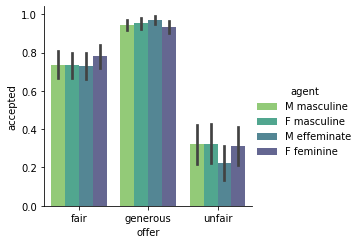

In [54]:
sn.catplot(x ="offer", y="accepted", hue ="agent",  data=two, kind="bar", palette='viridis_r', alpha=.85, height=3.5, aspect=1.1)

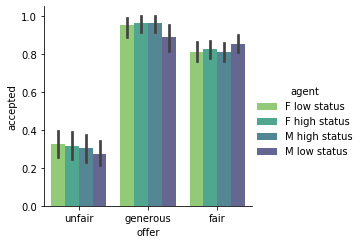

In [55]:
sn.catplot(x ="offer", y="accepted", hue ="agent",  data=three, kind="bar", palette='viridis_r', alpha=.85, height=3.5, aspect=1.1)

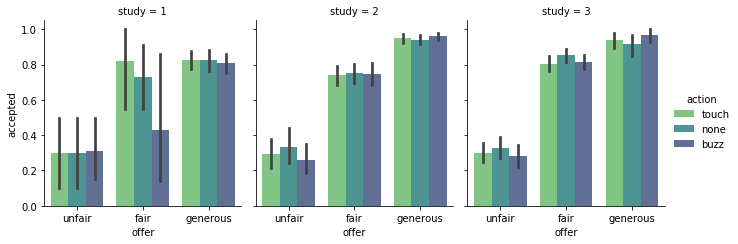

In [56]:
# TOUCH X OFFER COMPLIANCE

sn.catplot(x="offer", y="accepted", hue ="action", col = 'study', order=['unfair', 'fair', 'generous'], data=res, kind="bar", palette='viridis_r', alpha=.85, height=3.5, aspect=.9)

## Heart rate

In [57]:
long = res[['study', 'agent', 'agent_gender', 'masculinity_look','status_look', 'action', 0, 1, 2, 3, 4, 5]]

#the new column 'feature' contains the previous names of variables, the variable 'rate' contains its values
long = pd.melt(long,id_vars=['study', 'agent', 'agent_gender', 'masculinity_look','status_look', 'action'], var_name='second', value_name='heart_rate_change') 

In [58]:
long

study          agent agent_gender masculinity_look status_look action  \
0          1         female       female         feminine      medium  touch   
1          1           male         male        masculine      medium   none   
2          1         female       female         feminine      medium  touch   
3          1         female       female         feminine      medium   buzz   
4          1           male         male        masculine      medium  touch   
...      ...            ...          ...              ...         ...    ...   
27229      3  M high status         male        masculine        high   buzz   
27230      3   F low status       female         feminine         low  touch   
27231      3   M low status         male        masculine         low   buzz   
27232      3   M low status         male        masculine         low   buzz   
27233      3  M high status         male        masculine        high   none   

      second  heart_rate_change  
0          0                0.0  
1          0                0.0  
2          0                0.0  
3          0                0.0  
4          0                0.0  
...      ...                ...  
27229      5                NaN  
27230      5                NaN  
27231      5                NaN  
27232      5                NaN  
27233      5                NaN  

[27234 rows x 8 columns]

In [59]:
tukey3 = pairwise_tukeyhsd(endog=long.heart_rate_change,     # Data
                          groups=long.action,   # Groups
                          alpha=0.001)          # Significance level
tukey3.summary()
# See test summary


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.


C:\Users\justy\Anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1299: RuntimeWarning: invalid value encountered in greater
  reject = st_range > q_crit
C:\Users\justy\Anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:1301: RuntimeWarning: invalid value encountered in greater
  reject2 = np.abs(meandiffs) > crit_int


<class 'statsmodels.iolib.table.SimpleTable'>

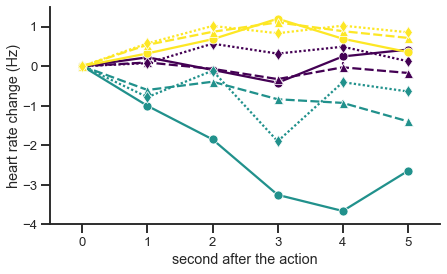

In [60]:
sn.set_context("talk", font_scale=.8)

plt.figure(figsize=(7,4))

sn.set_style('white')

ax = plt.gca()

f = sn.lineplot(x=long.loc[:,"second"], y=long.loc[:,"heart_rate_change"], style =  long.loc[:,"action"], hue = long.loc[:,"study"], data=long, 
                markers = ["o", "^", "d"], err_style='bars', palette="viridis", ci=1, n_boot=100,
                legend=False)


#**line_kws={'ls': '-' })
#plt.xlines(ymin=-2.5,ymax=.5, color="red")
plt.ylim(-4,1.5)
plt.xlim(-.5,5.5)
plt.ylabel("heart rate change (Hz)", labelpad=1)
plt.xlabel("second after the action")
#plt.legend(title="action",labels=["none", "buzz", "touch"], loc="lower left")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

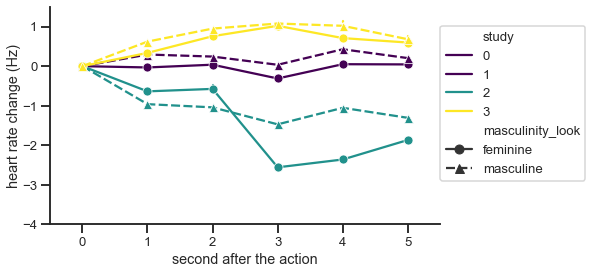

In [61]:
sn.set_context("talk", font_scale=.8)

plt.figure(figsize=(7,4))

sn.set_style('white')

ax = plt.gca()

f = sn.lineplot(x=long.loc[:,"second"], y=long.loc[:,"heart_rate_change"], style =  long.loc[:,"masculinity_look"], hue = long.loc[:,"study"], data=long, 
                markers = ["o", "^"], err_style='bars', palette="viridis", ci=1, n_boot=100,
                legend='brief')

plt.legend(loc=[1,.2])
#**line_kws={'ls': '-' })
#plt.xlines(ymin=-2.5,ymax=.5, color="red")
plt.ylim(-4,1.5)
plt.xlim(-.5,5.5)
plt.ylabel("heart rate change (Hz)", labelpad=1)
plt.xlabel("second after the action")
#plt.legend(title="action",labels=["none", "buzz", "touch"], loc="lower left")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

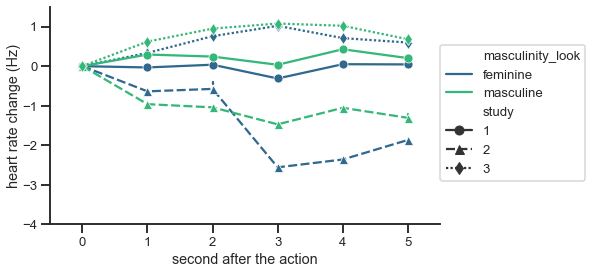

In [62]:
sn.set_context("talk", font_scale=.8)

plt.figure(figsize=(7,4))

sn.set_style('white')

ax = plt.gca()

f = sn.lineplot(x=long.loc[:,"second"], y=long.loc[:,"heart_rate_change"], style =  long.loc[:,"study"], hue  =  long.loc[:,"masculinity_look"], data=long, 
                markers = ["o", "^", "d"], err_style='bars', palette="viridis", ci=1, n_boot=100,
                legend='brief')

plt.legend(loc=[1,.2])
#**line_kws={'ls': '-' })
#plt.xlines(ymin=-2.5,ymax=.5, color="red")
plt.ylim(-4,1.5)
plt.xlim(-.5,5.5)
plt.ylabel("heart rate change (Hz)", labelpad=1)
plt.xlabel("second after the action")
#plt.legend(title="action",labels=["none", "buzz", "touch"], loc="lower left")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')